In [50]:
import pymongo
import math 
import pandas as pd
import numpy as np
import pylab
from scipy import stats

from  qgrid import show_grid as show 
from datetime import datetime

client = pymongo.MongoClient('172.16.45.8', 27017)
db = client.rapls
sensors= db.sensor

In [54]:
def get_times(target,source=db.testcases):
    x= list(db.testcases.find({'name':target}))[0]
    x['execution']=datetime.utcfromtimestamp(int(x['execution']))
    x['begin']=datetime.utcfromtimestamp(int(x['begin']))
    x['end']=datetime.utcfromtimestamp(int(x['end']))
    x['warmup']=datetime.utcfromtimestamp(int(x['warmup']))
    return x 

def calculate_power(target , source=db.sensor):
    times=get_times(target)
    df = pd.DataFrame.from_dict(list(sensors.find({'timestamp' :{'$gte':times['begin'],'$lte':times['end']}})))
    result=df[df.target== target][["_id","rapl","timestamp"]]
    system=df[df.target== "system"] 
    result["rapl"]=result.apply(lambda row :math.ldexp(  system[system.timestamp==row['timestamp']].rapl.iloc[0]['0']['38']['RAPL_ENERGY_PKG'],-32), axis=1)
#     result['timestamp']= result.apply(lambda row :int(row['timestamp'].timestamp()),axis=1)
    return result

def calculate_energy(targetname) : 
    
    times=get_times(targetname)
    target=calculate_power(targetname)
    warmup = target[(target.timestamp >= times['warmup']) & (target.timestamp < times['execution']) ].loc[:,"rapl"].sum() 
    execution = target[(target.timestamp >= times['execution']) ].loc[:,"rapl"].sum() 
    return {'warmup':warmup,'execution': execution} 

def get_recap(target):
    energy=calculate_energy(target['name'])
    return {'name': target['name'] 
            ,'warmup time': int(target['execution'])-int(target['warmup']) 
            ,'warmup energy': energy['warmup'] 
            ,'execution time': int(target['end'])-int(target['execution']) 
            ,'execution energy': energy['execution']}

In [77]:
import re
regx = re.compile("tommtiv1int2.+", re.IGNORECASE)
times=pd.DataFrame.from_dict(list(db.testcases.find({"name":regx})))
# data = pd.DataFrame(columns=['name','warmup time','warmup energy','execution time ','execution energy']) 
data=[]
times.apply(lambda row: data.append(get_recap(row)), axis=1)
    
data=pd.DataFrame.from_dict(data)
show(data)
# data

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

(0.708749532699585, 0.0003087418444920331)


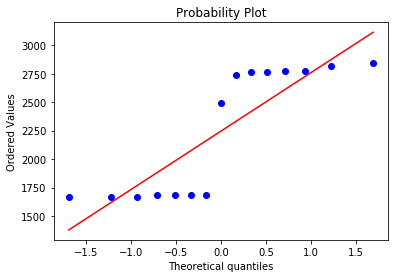

In [89]:
x=data['execution energy'].iloc[0:]
print(stats.shapiro(x))
stats.probplot(x, dist="norm", plot=pylab)
pylab.show()

<IPython.core.display.Javascript object>


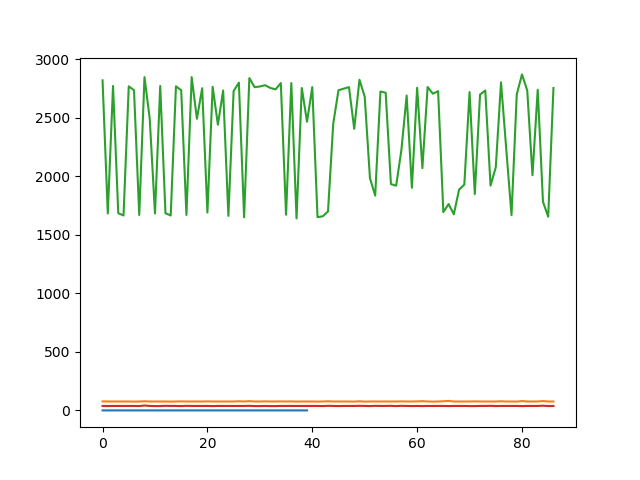

In [102]:
from matplotlib import pyplot
%matplotlib notebook 
l=[stats.shapiro(data['execution energy'].iloc[0:x])[1] for x in range(3,86)]
pyplot.plot(l)

<IPython.core.display.Javascript object>


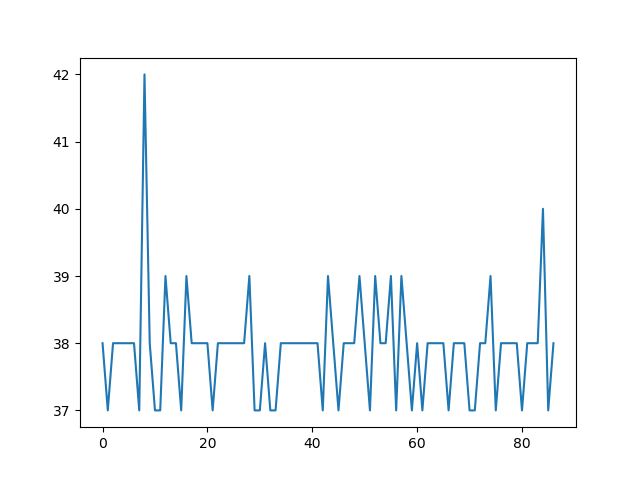

In [106]:
pyplot.plot(data['warmup time'])